In [49]:
import pandas as pd
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [50]:
#input data
def input_data(folder):
    cv = pd.read_csv(folder+'/' + folder + '_photos_calib_result.csv')
    cv['pupil'] = pd.to_numeric(cv['pupil'], errors='coerce')
    cv['ratio'] = pd.to_numeric(cv['ratio'], errors='coerce')
    cv['x'] = pd.to_numeric(cv['x'], errors='coerce')
    cv['y'] = pd.to_numeric(cv['y'], errors='coerce')
    cv['ts'] = pd.to_numeric(cv['ts'], errors='coerce')
    cv['ts'] = np.around(cv['ts'], decimals=0)
    #seperate by steps
    cv = cv[cv['pupil'] > 0] #remove zeros
    
    s30_cv = cv[cv['step'] == 30]
    s31_cv = cv[cv['step'] == 31]
    s32_cv = cv[cv['step'] == 32]
    
    return cv, s30_cv, s31_cv, s32_cv

def input_eve_data(folder, step, step_num):
    left_pupil_db = pd.DataFrame(np.array(h5.File(folder+'/' + step + '_webcam_c.h5')['left_p']['data']))
    right_pupil_db = pd.DataFrame(np.array(h5.File(folder+'/' + step + '_webcam_c.h5')['right_p']['data']))
    px_2_mm = pd.DataFrame(np.array(h5.File(folder+'/' + step + '_webcam_c.h5')['pixels_per_millimeter']))
    gaze_right = pd.DataFrame(np.array(h5.File(folder+'/' + step + '_webcam_c.h5')['right_o']['data']))
    gaze_left = pd.DataFrame(np.array(h5.File(folder+'/' + step + '_webcam_c.h5')['left_o']['data']))
    gaze_left = gaze_left.rename(columns={0: 'x', 1: 'y', 2: 'z'})
    gaze_right = gaze_right.rename(columns={0: 'x', 1: 'y', 2: 'z'})
    scale = pd.DataFrame(np.array(h5.File(folder+'/' + step + '_webcam_c.h5')['pixels_per_millimeter']))
    scale = scale[0][0]
    
    #normalise input data
    #eve db
    left_pupil_db *= scale
    right_pupil_db *= scale
    
    #insert the timestamp information for the eve data
    ts_eve = attach_ts(step_num, folder)
    left_pupil_db['ts'] = ts_eve
    
    # integrate into one dataframe with the coordinate
    left_pupil_db['x'] = gaze_left['x']
    left_pupil_db['y'] = gaze_left['y']

    right_pupil_db['ts'] = ts_eve
    right_pupil_db['x'] = gaze_right['x']
    right_pupil_db['y'] = gaze_right['y']

    left_pupil_db = left_pupil_db.rename(columns={0: 'pupil'})
    right_pupil_db = right_pupil_db.rename(columns={0: 'pupil'})
    left_pupil_db = left_pupil_db[left_pupil_db['pupil'] != 0]
    right_pupil_db = right_pupil_db[right_pupil_db['pupil'] != 0]
    
    return left_pupil_db, right_pupil_db, ts_eve

def attach_ts(stepnum, folder):
    f = open(folder+'/step_' + stepnum +'_webcam_c.timestamps.txt','r')
    ts = []
    for line in f.readlines():
        ts.append(float(line[:-1]))

    start = ts[0]
    for i in range(len(ts)):
        ts[i] -= start
        ts[i] /= 1000000 #from ms to s
        ts[i] = np.around(ts[i], decimals=0)
    return ts


In [51]:
from statsmodels.stats.stattools import medcouple
import math

def get_quartiles(arr):
    arr = [i for i in arr if not np.isnan(i)]
    arr = np.sort(arr)
    mid = int(len(arr)/2)
    if(len(arr)%2 == 0):
        Q1 = np.median(arr[:mid])
        Q3 = np.median(arr[mid:])
    else:
        Q1 = np.median(arr[:mid])
        Q3 = np.median(arr[mid:])
    return Q1,Q3

def adjust_boxplot(values, param, bias=1.5):
    mc = np.around(medcouple(values), decimals=1)
    
    if mc == 0: #tukeys method
        q1,q3 = get_quartiles(values)
        iqr = q3 - q1
        lowerLimit = np.around(q1 - bias*iqr, decimals=2)
        upperLimit = np.around(q3 + bias*iqr, decimals=2)
    else:
        q1,q3 = get_quartiles(values)
        iqr = q3 - q1
        if mc > 0:
            lowerLimit = np.around(q1 - bias*math.exp(-3.5*mc)*iqr, decimals=2)
            upperLimit = np.around(q3 + bias*math.exp(4*mc)*iqr, decimals=2)
        else:
            lowerLimit = np.around(q1 - bias*math.exp(-4*mc)*iqr, decimals=2)
            upperLimit = np.around(q3 + bias*math.exp(3.5*mc)*iqr, decimals=2)
        
    result = []
    for v in values:
        if v < lowerLimit or v > upperLimit: 
            result.append(0)
        else:
            result.append(v)
    
    remove = np.around(1-(len([i for i in result if i != 0])/len(values)), decimals=2)

    return result

def remove_outliers(df, param, bias=1.5): 
    ad_value = adjust_boxplot(list(df[param]), param, bias)
    df[param] = ad_value
    df = df[df[param] != 0]
    
    return df


In [52]:
#merge function for cv db
def merge_both_side(ts, df_left, df_right):
    data = []
    
    for t in ts:
        left_series = df_left[df_left['ts'] == t]
        right_series = df_right[df_right['ts'] == t]
        
        if len(left_series) != 0:
            left = list(left_series['pupil'])[0]
            y_left = list(left_series['y'])[0]
            x_left = list(left_series['x'])[0]
        else:
            left, y_left, x_left = np.nan, np.nan, np.nan
        
        if len(right_series) != 0:
            right = list(right_series['pupil'])[0]
            y_right = list(right_series['y'])[0]
            x_right = list(right_series['x'])[0]
        else:
            right, y_right, x_right = np.nan, np.nan, np.nan
        
        if not np.isnan(left) and not np.isnan(right):
            data.append([t, np.mean([left, right])])
        elif not np.isnan(right):
            data.append([t, right])
        elif not np.isnan(left):
            data.append([t, left])
        else:
            data.append([t, np.nan])
        
    df = pd.DataFrame(data, columns=['ts', 'pupil'])
    df['pcps'] = df['pupil'].pct_change()
    df = df[df['pupil'] != np.nan]
    return df


In [53]:
### normalise into 1sec
def nor_1000(df, sec=1):
    video_length = np.around(list(df['ts'])[-1]/1000, decimals=0)

    times = np.arange(0, video_length*1000, (1000*sec)) #interval
    start = 0
    data = []
    for t in times[1:]:
        rows = df[ (df['ts'] >= start) & (df['ts'] <= t)]
        values = sorted([i for i in rows['pupil'] if i != 0])
        data.append([start, np.around(np.nanmean(values), decimals=3)])
        start = t
        
    result = pd.DataFrame(data, columns=['ts', 'pupil'])   
    result['pcps'] = result['pupil'].pct_change()
    return result 

def preprocess(step_cv_df, folder, step, step_num):
    ts_cv = []
    for t in list(step_cv_df['ts']): #the whole ts list before removing any values
        if t not in ts_cv:
            ts_cv.append(t)
    
    #input eve data
    left_pupil_eve, right_pupil_eve, ts_eve = input_eve_data(folder, step, step_num)
    
    #clean cv data
    before_size = len(list(step_cv_df['pupil']))
    step_cv_df = remove_outliers(step_cv_df, 'pupil')
    step_cv_df = remove_outliers(step_cv_df, 'y', 3)
    step_cv_df = remove_outliers(step_cv_df, 'x', 3)
    
    print('** after clean cv data, remove ratio', 1-(len(list(step_cv_df['pupil']))/before_size), '\n')

    changes_cv_left = step_cv_df[step_cv_df['side'] == 'L'] #select individual side
    changes_cv_right = step_cv_df[step_cv_df['side'] == 'R']
    
    #clean eve data
    left_pupil_eve = remove_outliers(left_pupil_eve, 'pupil')
    right_pupil_eve = remove_outliers(right_pupil_eve, 'pupil')
    
    cv = merge_both_side(ts_cv, changes_cv_left, changes_cv_right)
    eve = merge_both_side(ts_eve, left_pupil_eve, right_pupil_eve) 
    
    video_length = np.around(list(eve['ts'])[-1]/1000, decimals=0)
    freq_eve = np.around(len(eve['pupil'])/video_length, decimals=0)
    freq_cv = np.around(len(cv['pupil'])/video_length, decimals=0)
    print('eve freq = ', freq_eve, ' | cv freq = ', freq_cv)
    return cv, eve

In [54]:
from scipy.stats import pearsonr      

def windowed_corr(df, window=3, overlap=0):
    #overall pearson correlation    
    df = df.dropna(subset=['pupil'])
        
    r, p = pearsonr(list(df['ts']), list(df['pupil']))
    print('overall pearson correlation (r, p):', np.around(r, decimals=3), np.around(p, decimals=3))
    return r,p
#     #windowed pearson correlation
#     print('\t-- with window --')
#     length = list(df['ts'])[-1]

#     idx = np.arange(0, length, (window-overlap)*1000)
#     positive, negative, total = 0, 0, 0
    
#     start = 0
#     for t in idx[1:]:
#         rows = df[(df['ts'] >= start) & (df['ts'] < t)]

#         if len(rows) >= 2: 
#             corr = pearsonr(list(rows['ts']), list(rows['pupil']))
#         else:
#             corr = [0,0]
#         print('\t\tcorrelation (r, p) at window ', window, ':', np.around(corr, decimals=3))
#         total += 1
        
#         if corr[0] > 0.5:
#             positive += 1
#         if corr[0] < -0.5:
#             negative += 1
#         start = t
    
#     print('position cor, negative cor, total:', positive, negative, total)


In [61]:
from scipy import fft

def run(step_num, step_cv_df, folder):
    step_num = str(step_num)
    step = 'step_' + step_num
    save_file = folder+'/'+step
    suffix = 'video' 
    cv, eve = preprocess(step_cv_df, folder, step, step_num)
    print(f'\n**{step}')
    
    for i in range(6):
        try:
            print(f'\t-- {i+1} SEC Timeframe --')
            cv_new = nor_1000(cv, i+1)
            eve_new = nor_1000(eve, i+1)
            print('cv length', len(cv_new), 'eve length', len(eve_new))
            print('[cv]')
            rcv, pcv = windowed_corr(cv_new)
            print('[eve]')
            re, pe = windowed_corr(eve_new)
            print(f'-- diff: {rcv-re}, {pcv-pe}')
            
            x_cv = fft.fftfreq(len(cv_new['pcps']))
            y_cv = fft.fft(cv_new[['pcps']])
#             print('FT cv', y_cv)
            x_eve = fft.fftfreq(len(eve_new[['pcps']]))
            y_eve = fft.fft(eve_new[['pcps']])
#             print('FT eve', y_eve)
            
            fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 6))
            ax1.stem(y_cv, x_cv, label='cv')
            ax2.stem(y_eve, x_eve, label='eve')
#             plt.plot(y_eve, label='diff')
            ax2.set_xlabel("Amplitude")
            ax2.set_ylabel("Frequency [Hz]")
            ax1.grid()
            ax2.grid()
            ax1.legend(loc='best')
            ax2.legend(loc='best')
            plt.show()
        except:
            continue

C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


** after clean cv data, remove ratio 0.04397705544933084 

eve freq =  30.0  | cv freq =  27.0

**step_30
	-- 1 SEC Timeframe --
cv length 9 eve length 9
[cv]
overall pearson correlation (r, p): 0.28 0.465
[eve]
overall pearson correlation (r, p): 0.147 0.706
-- diff: 0.13343344676555075, -0.2410290746908102


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


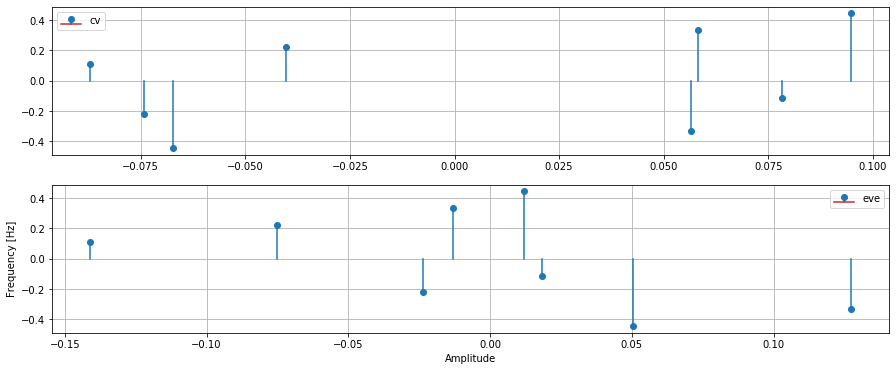

	-- 2 SEC Timeframe --
cv length 4 eve length 4
[cv]
overall pearson correlation (r, p): 0.39 0.61
[eve]
overall pearson correlation (r, p): 0.041 0.959
-- diff: 0.34918819424448866, -0.34918819424448855


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


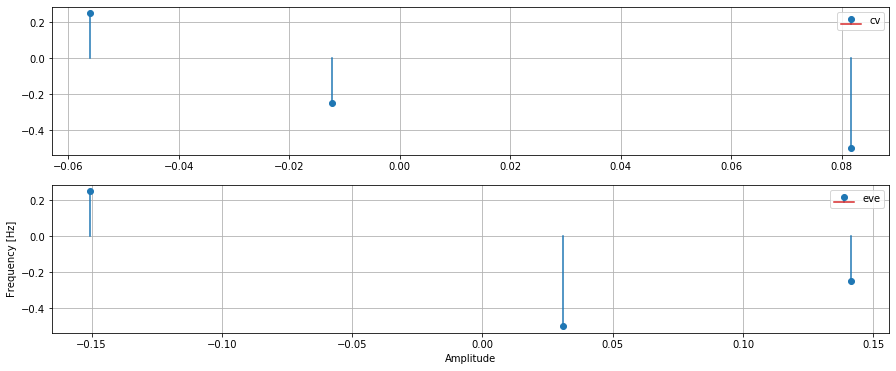

	-- 3 SEC Timeframe --
cv length 3 eve length 3
[cv]
overall pearson correlation (r, p): 0.99 0.089
[eve]
overall pearson correlation (r, p): 0.356 0.768
-- diff: 0.634362316221789, -0.6789684072603273


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


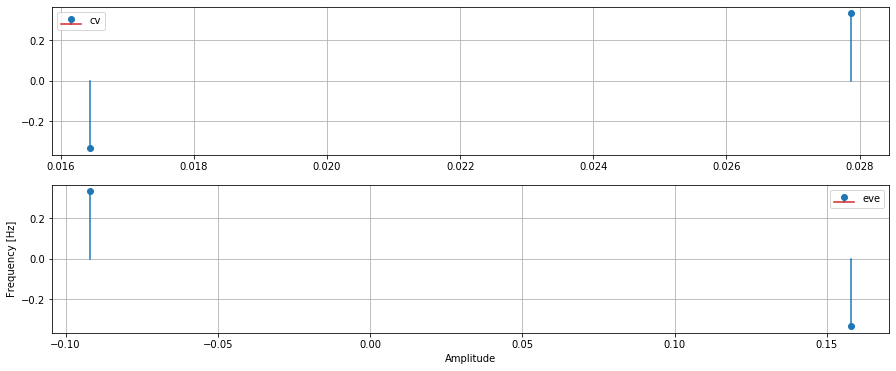

	-- 4 SEC Timeframe --
cv length 2 eve length 2
[cv]
overall pearson correlation (r, p): 1.0 1.0
[eve]
overall pearson correlation (r, p): 1.0 1.0
-- diff: 0.0, 0.0


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


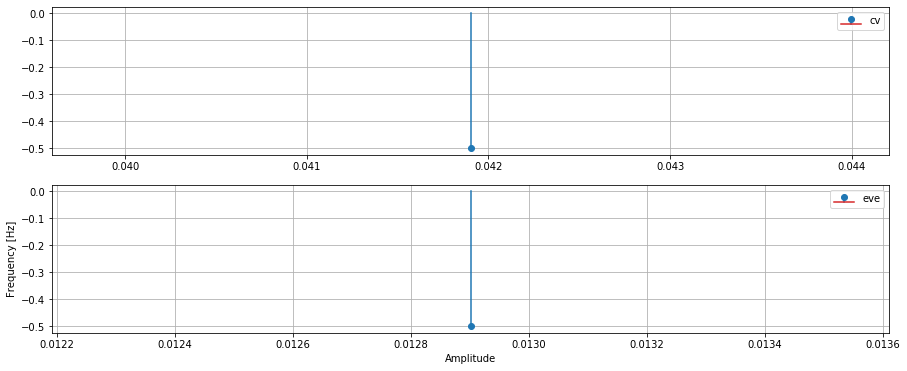

	-- 5 SEC Timeframe --
cv length 1 eve length 1
[cv]
	-- 6 SEC Timeframe --
cv length 1 eve length 1
[cv]
** after clean cv data, remove ratio 0.11759082217973227 

eve freq =  30.0  | cv freq =  17.0

**step_31
	-- 1 SEC Timeframe --
cv length 49 eve length 49
[cv]
overall pearson correlation (r, p): -0.074 0.615
[eve]
overall pearson correlation (r, p): 0.115 0.432
-- diff: -0.18943688442824877, 0.18338599898512414


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


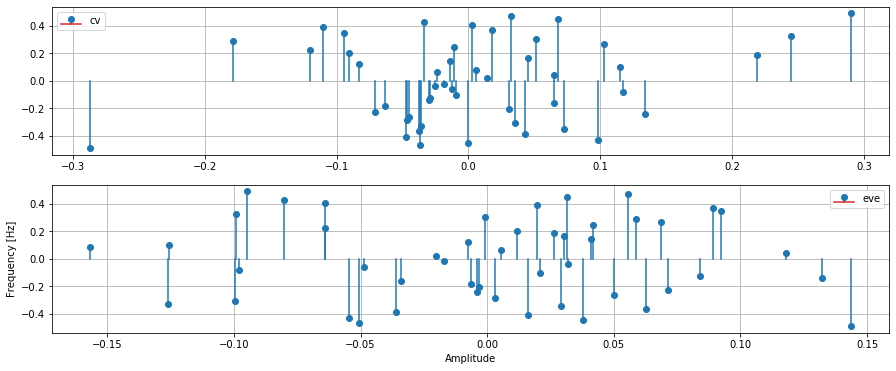

	-- 2 SEC Timeframe --
cv length 24 eve length 24
[cv]
overall pearson correlation (r, p): -0.097 0.653
[eve]
overall pearson correlation (r, p): 0.123 0.566
-- diff: -0.22005000315821505, 0.08621713879252912


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


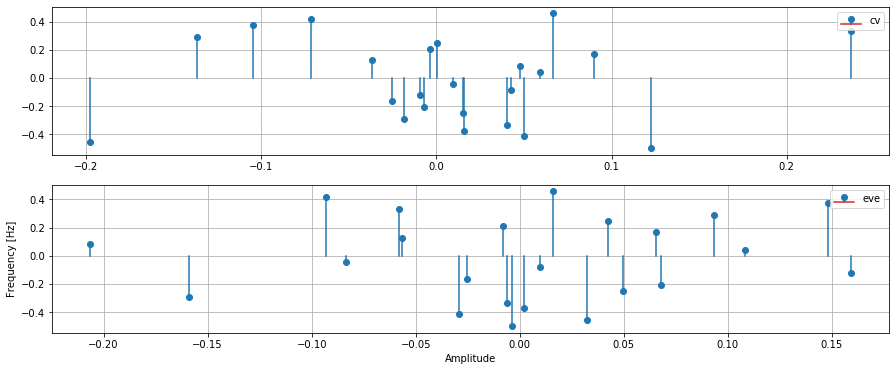

	-- 3 SEC Timeframe --
cv length 16 eve length 16
[cv]
overall pearson correlation (r, p): -0.1 0.714
[eve]
overall pearson correlation (r, p): 0.135 0.617
-- diff: -0.2349488121365596, 0.09658181109235553


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


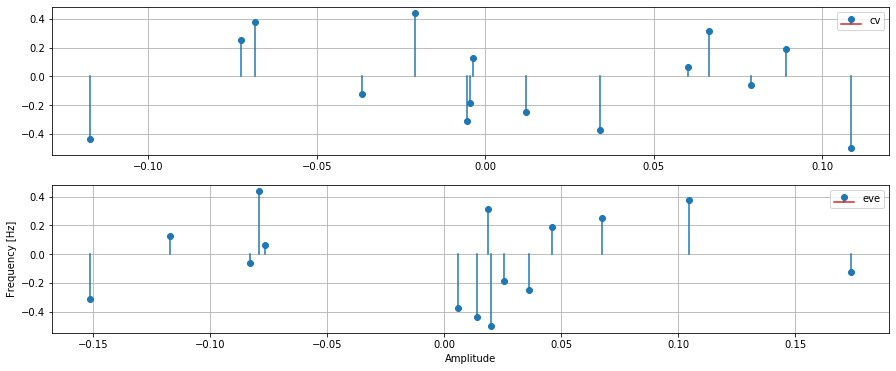

	-- 4 SEC Timeframe --
cv length 12 eve length 12
[cv]
overall pearson correlation (r, p): -0.071 0.825
[eve]
overall pearson correlation (r, p): 0.139 0.666
-- diff: -0.2106911963866336, 0.15946522242826744


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


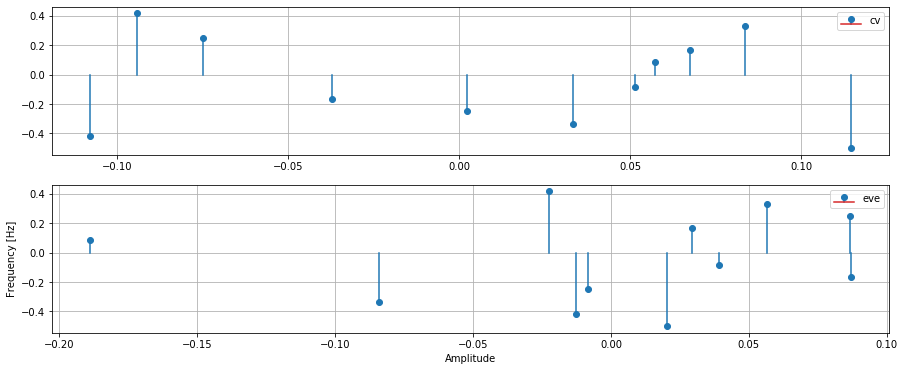

	-- 5 SEC Timeframe --
cv length 9 eve length 9
[cv]
overall pearson correlation (r, p): -0.31 0.417
[eve]
overall pearson correlation (r, p): 0.1 0.799
-- diff: -0.4097904286700823, -0.38179655774044424


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


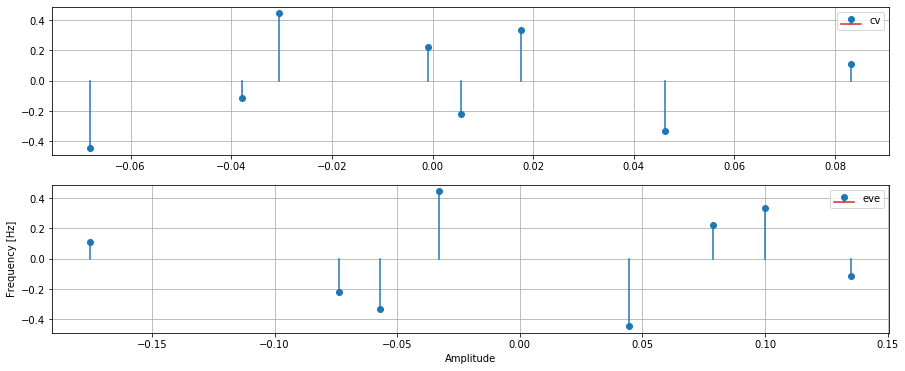

	-- 6 SEC Timeframe --
cv length 8 eve length 8
[cv]
overall pearson correlation (r, p): -0.174 0.68
[eve]
overall pearson correlation (r, p): 0.207 0.623
-- diff: -0.3809685622573342, 0.05742528576996664


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


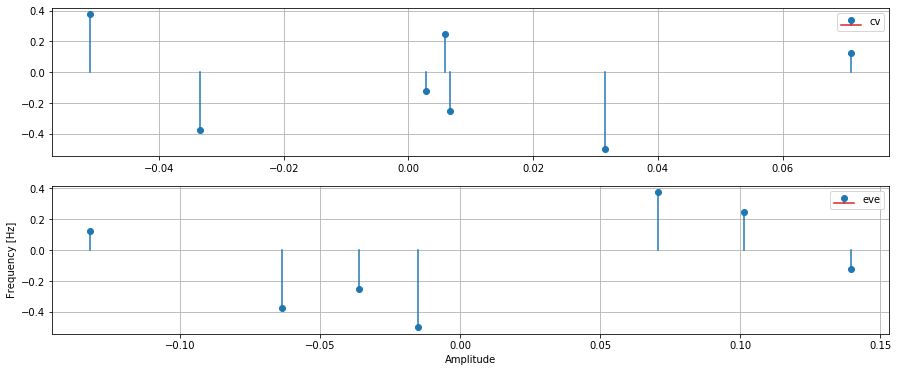

** after clean cv data, remove ratio 0.13364055299539168 

eve freq =  30.0  | cv freq =  12.0

**step_32
	-- 1 SEC Timeframe --
cv length 29 eve length 29
[cv]
overall pearson correlation (r, p): -0.211 0.291
[eve]
overall pearson correlation (r, p): -0.112 0.564
-- diff: -0.09922695478287241, -0.2730448314564668


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


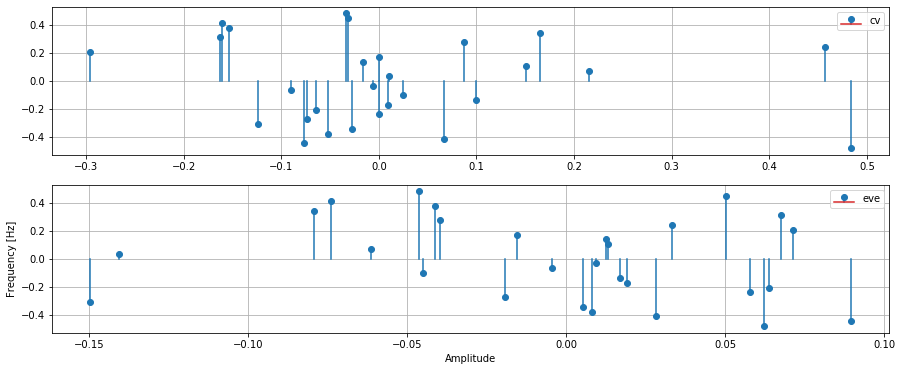

	-- 2 SEC Timeframe --
cv length 14 eve length 14
[cv]
overall pearson correlation (r, p): -0.371 0.192
[eve]
overall pearson correlation (r, p): -0.133 0.651
-- diff: -0.2381701306856369, -0.4595243521031249


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


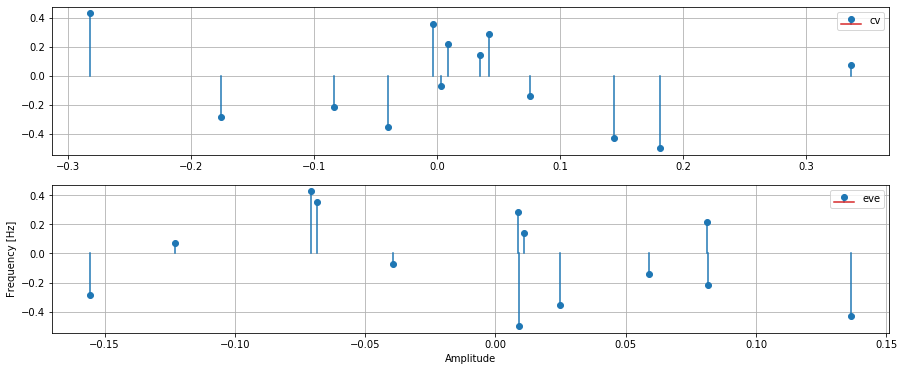

	-- 3 SEC Timeframe --
cv length 9 eve length 9
[cv]
overall pearson correlation (r, p): -0.249 0.518
[eve]
overall pearson correlation (r, p): -0.149 0.703
-- diff: -0.1005706313178584, -0.1848385888465499


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


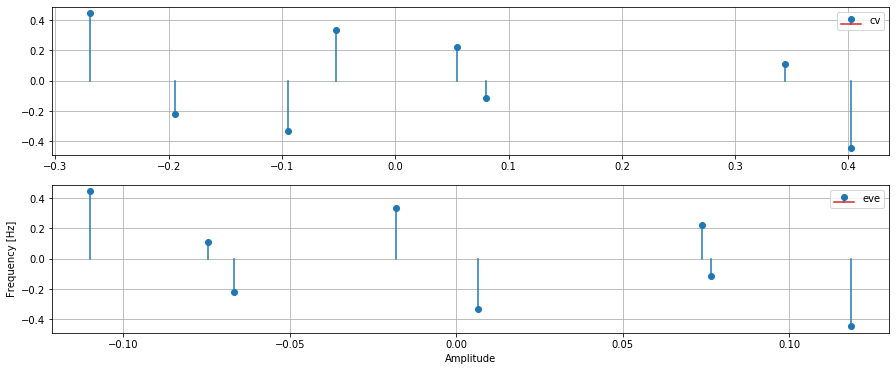

	-- 4 SEC Timeframe --
cv length 7 eve length 7
[cv]
overall pearson correlation (r, p): -0.387 0.39
[eve]
overall pearson correlation (r, p): -0.162 0.729
-- diff: -0.22558756166009591, -0.3383068508339719


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


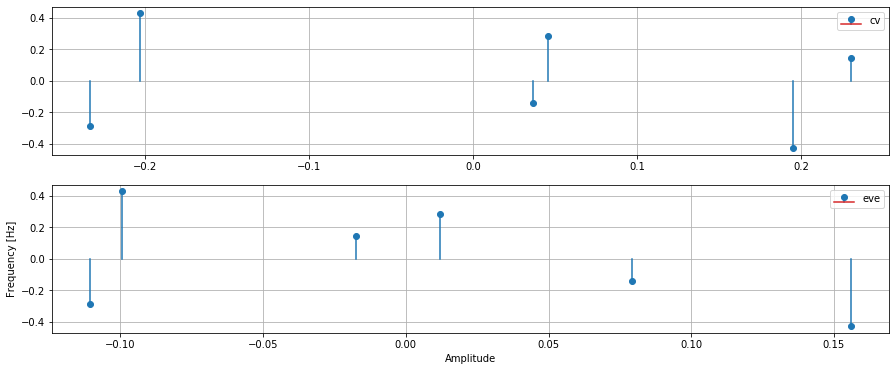

	-- 5 SEC Timeframe --
cv length 5 eve length 5
[cv]
overall pearson correlation (r, p): -0.205 0.741
[eve]
overall pearson correlation (r, p): -0.36 0.552
-- diff: 0.15505904975990747, 0.18915525195867977


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


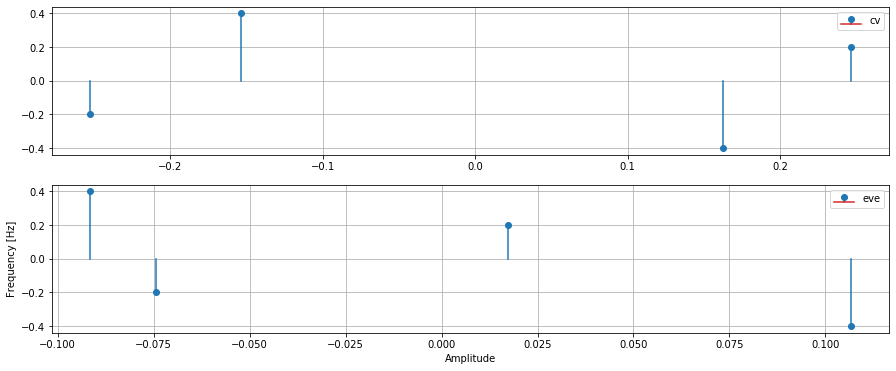

	-- 6 SEC Timeframe --
cv length 4 eve length 4
[cv]
overall pearson correlation (r, p): -0.233 0.767
[eve]
overall pearson correlation (r, p): -0.556 0.444
-- diff: 0.32370346545099427, 0.32370346545099427


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


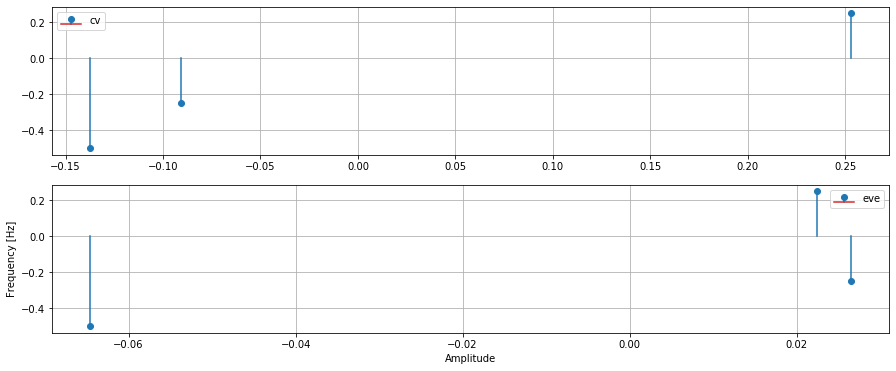

In [62]:
cv_36, s30_cv36, s31_cv36, s32_cv36 = input_data('train36')
run('30', s30_cv36, 'train36')
run('31', s31_cv36, 'train36')
run('32', s32_cv36, 'train36')

C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


** after clean cv data, remove ratio 0.15552855407047383 

eve freq =  30.0  | cv freq =  21.0

**step_30
	-- 1 SEC Timeframe --
cv length 29 eve length 29
[cv]
overall pearson correlation (r, p): -0.255 0.183
[eve]
overall pearson correlation (r, p): -0.028 0.885
-- diff: -0.22642025472656835, -0.7020546366394175


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


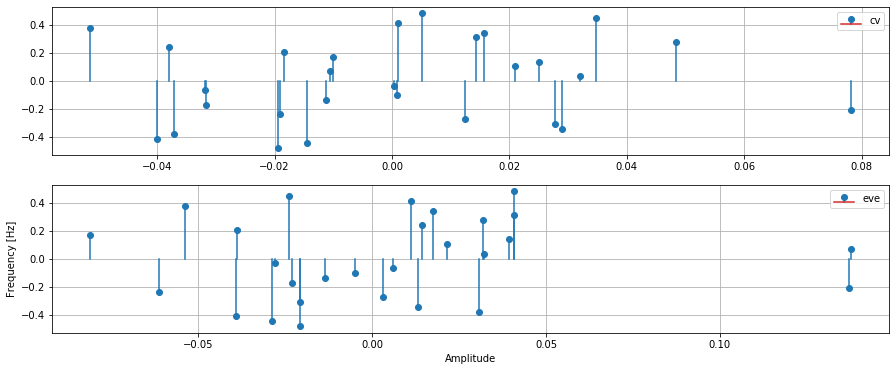

	-- 2 SEC Timeframe --
cv length 14 eve length 14
[cv]
overall pearson correlation (r, p): -0.228 0.433
[eve]
overall pearson correlation (r, p): 0.0 1.0
-- diff: -0.2282404943109027, -0.5671231685231901


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


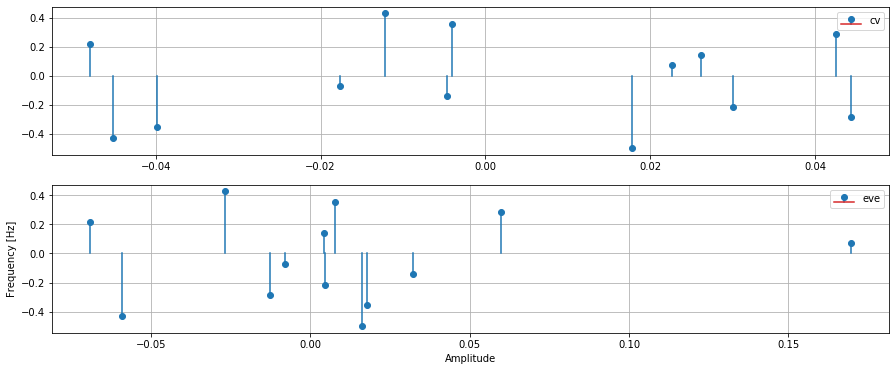

	-- 3 SEC Timeframe --
cv length 9 eve length 9
[cv]
overall pearson correlation (r, p): -0.151 0.699
[eve]
overall pearson correlation (r, p): -0.009 0.981
-- diff: -0.1412699304926056, -0.28205265517513134


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


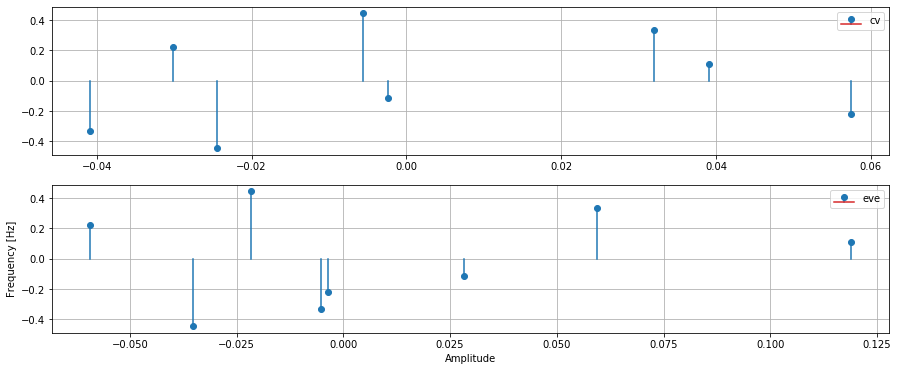

	-- 4 SEC Timeframe --
cv length 7 eve length 7
[cv]
overall pearson correlation (r, p): -0.239 0.606
[eve]
overall pearson correlation (r, p): -0.051 0.913
-- diff: -0.18809571219593113, -0.307928631049846


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


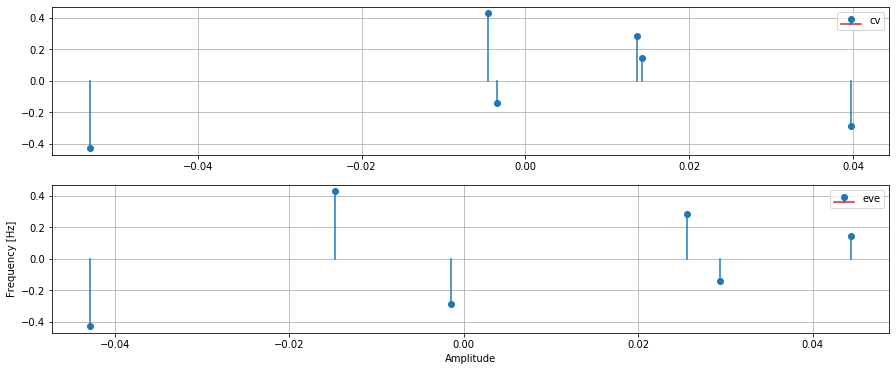

	-- 5 SEC Timeframe --
cv length 5 eve length 5
[cv]
overall pearson correlation (r, p): -0.308 0.614
[eve]
overall pearson correlation (r, p): -0.297 0.628
-- diff: -0.01147624743545339, -0.013928279739349847


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


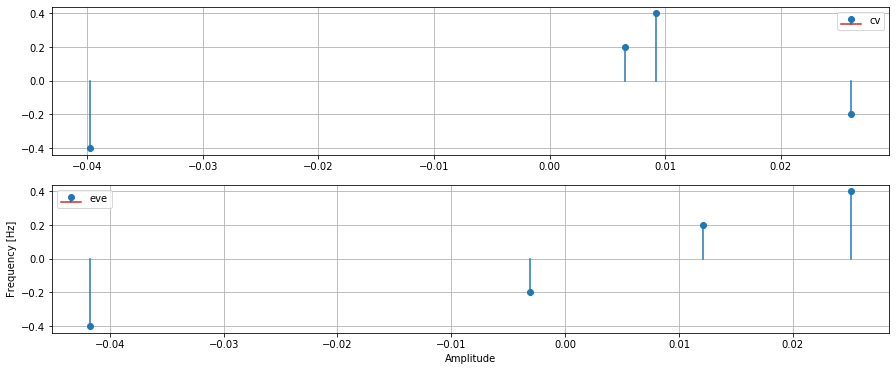

	-- 6 SEC Timeframe --
cv length 4 eve length 4
[cv]
overall pearson correlation (r, p): -0.748 0.252
[eve]
overall pearson correlation (r, p): -0.466 0.534
-- diff: -0.28177520646103893, -0.28177520646103893


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


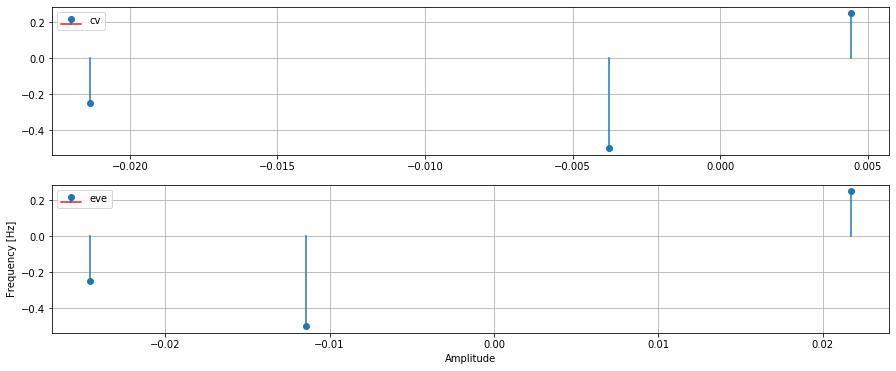

** after clean cv data, remove ratio 0.08892128279883382 

eve freq =  30.0  | cv freq =  17.0

**step_31
	-- 1 SEC Timeframe --
cv length 29 eve length 29
[cv]
overall pearson correlation (r, p): 0.153 0.427
[eve]
overall pearson correlation (r, p): 0.038 0.847
-- diff: 0.11586930916060588, -0.41980846626817536


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


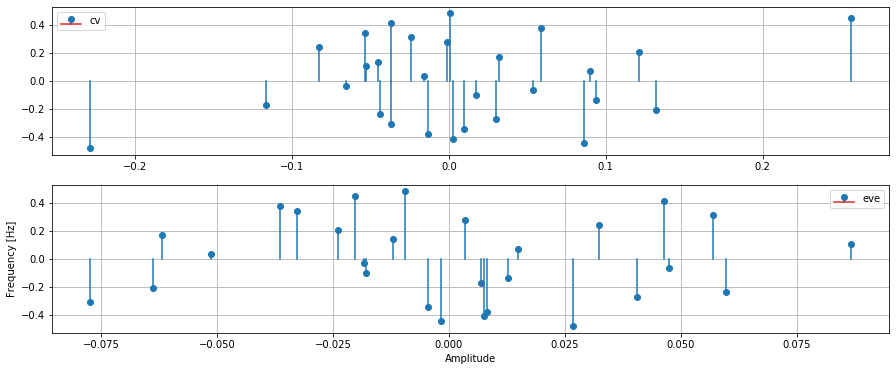

	-- 2 SEC Timeframe --
cv length 14 eve length 14
[cv]
overall pearson correlation (r, p): 0.215 0.46
[eve]
overall pearson correlation (r, p): 0.003 0.992
-- diff: 0.2121572731593305, -0.5317614283073756


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


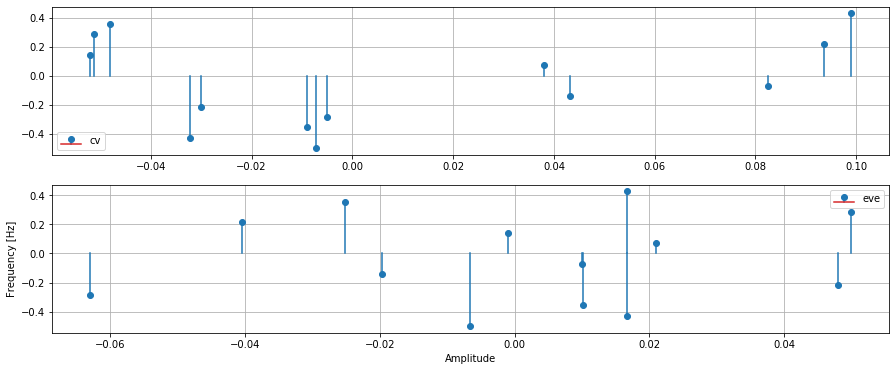

	-- 3 SEC Timeframe --
cv length 9 eve length 9
[cv]
overall pearson correlation (r, p): -0.005 0.99
[eve]
overall pearson correlation (r, p): 0.009 0.981
-- diff: -0.013938994212218406, 0.009188691628412626


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


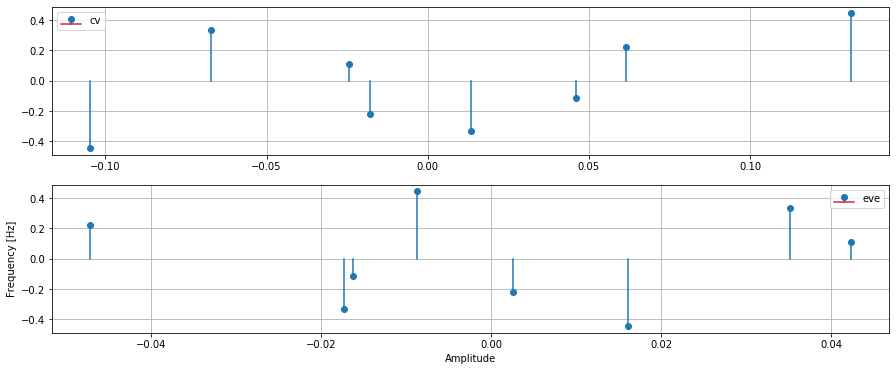

	-- 4 SEC Timeframe --
cv length 7 eve length 7
[cv]
overall pearson correlation (r, p): 0.24 0.604
[eve]
overall pearson correlation (r, p): -0.041 0.931
-- diff: 0.2803759683977117, -0.3267383665562097


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


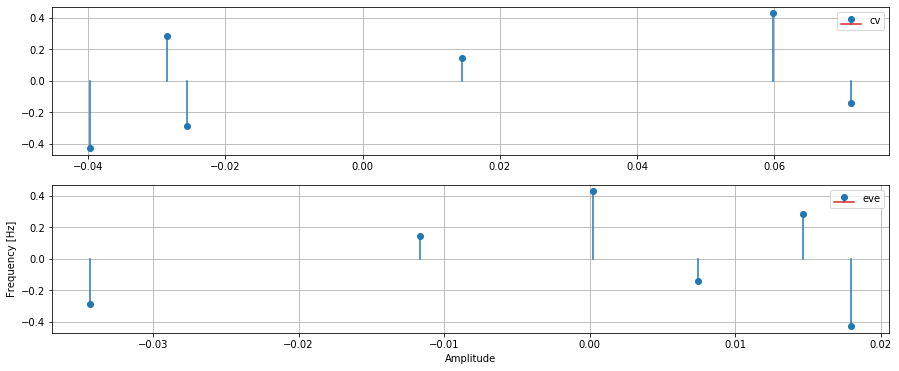

	-- 5 SEC Timeframe --
cv length 5 eve length 5
[cv]
overall pearson correlation (r, p): -0.425 0.476
[eve]
overall pearson correlation (r, p): -0.185 0.766
-- diff: -0.23979035717637062, -0.2899360074909179


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


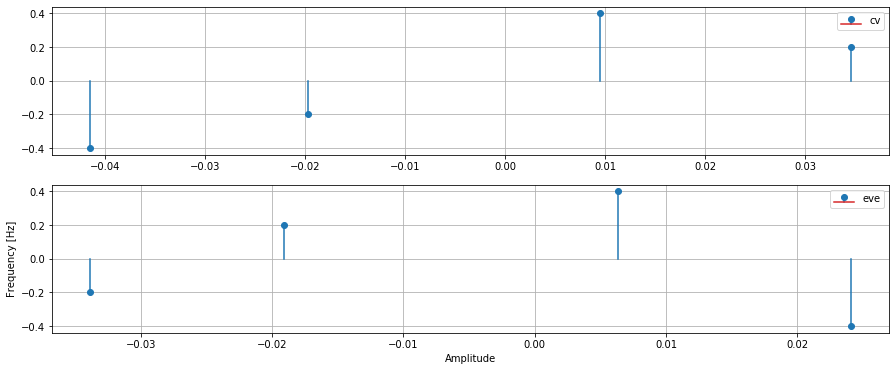

	-- 6 SEC Timeframe --
cv length 4 eve length 4
[cv]
overall pearson correlation (r, p): 0.069 0.931
[eve]
overall pearson correlation (r, p): 0.112 0.888
-- diff: -0.0431963448623925, 0.043196344862392544


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


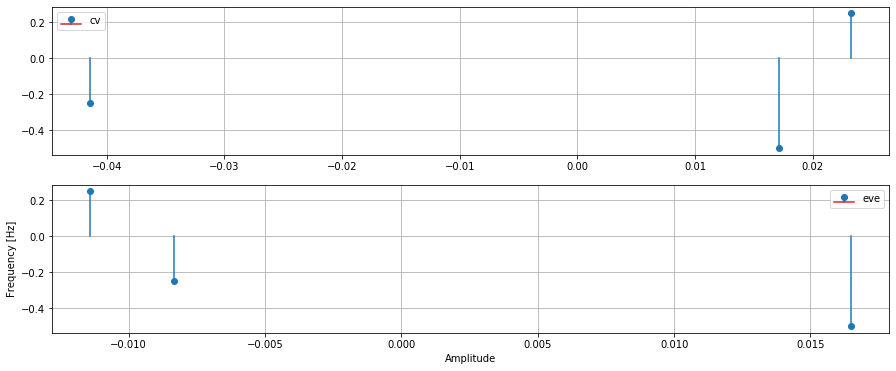

** after clean cv data, remove ratio 0.12935323383084574 

eve freq =  30.0  | cv freq =  16.0

**step_32
	-- 1 SEC Timeframe --
cv length 9 eve length 9
[cv]
overall pearson correlation (r, p): -0.44 0.236
[eve]
overall pearson correlation (r, p): 0.359 0.342
-- diff: -0.79941651268298, -0.10615430837555623


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


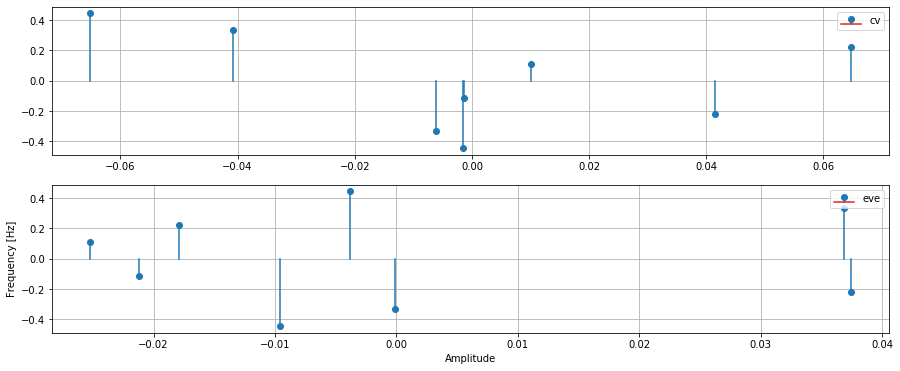

	-- 2 SEC Timeframe --
cv length 4 eve length 4
[cv]
overall pearson correlation (r, p): -0.531 0.469
[eve]
overall pearson correlation (r, p): 0.515 0.485
-- diff: -1.0454908677132697, -0.015727123868453763


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


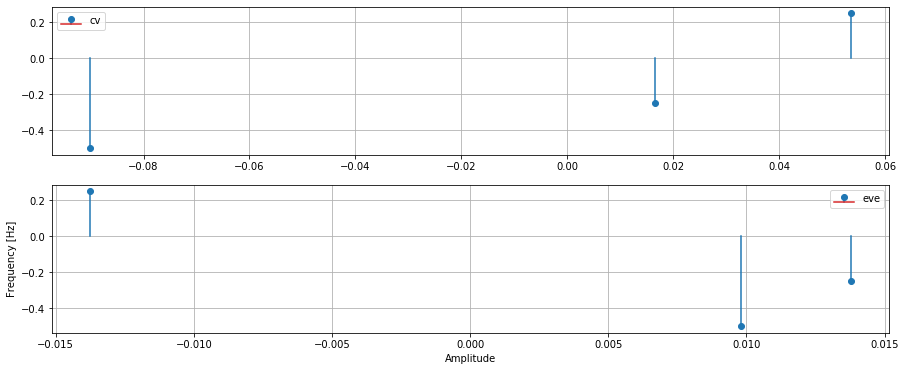

	-- 3 SEC Timeframe --
cv length 3 eve length 3
[cv]
overall pearson correlation (r, p): -0.922 0.253
[eve]
overall pearson correlation (r, p): 1.0 0.017
-- diff: -1.9216737729237237, 0.23637580712231476


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


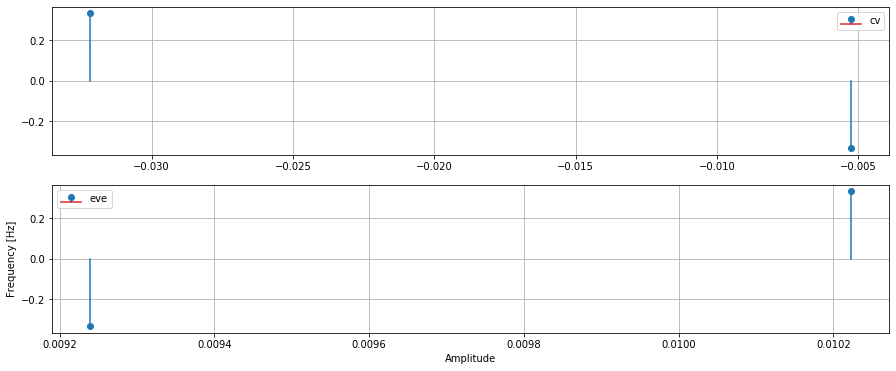

	-- 4 SEC Timeframe --
cv length 2 eve length 2
[cv]
overall pearson correlation (r, p): -1.0 1.0
[eve]
overall pearson correlation (r, p): 1.0 1.0
-- diff: -2.0, 0.0


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


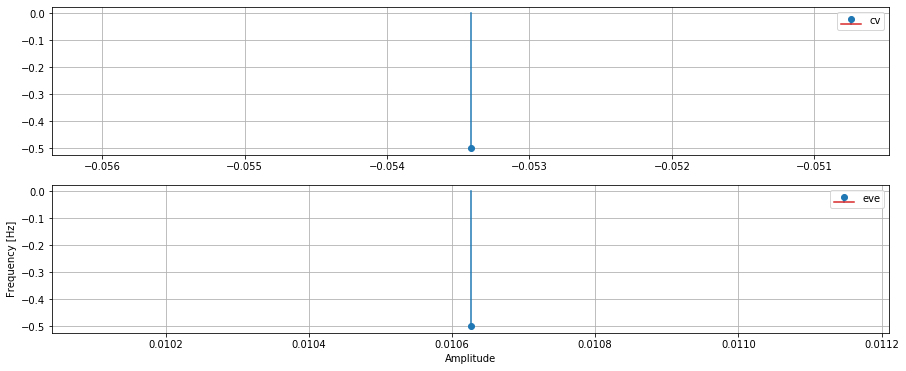

	-- 5 SEC Timeframe --
cv length 1 eve length 1
[cv]
	-- 6 SEC Timeframe --
cv length 1 eve length 1
[cv]


In [63]:
cv_38, s30_cv38, s31_cv38, s32_cv38 = input_data('train38')
run('30', s30_cv38, 'train38')
run('31', s31_cv38, 'train38')
run('32', s32_cv38, 'train38')

C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


** after clean cv data, remove ratio 0.09591836734693882 

eve freq =  30.0  | cv freq =  15.0

**step_30
	-- 1 SEC Timeframe --
cv length 29 eve length 29
[cv]
overall pearson correlation (r, p): -0.42 0.023
[eve]
overall pearson correlation (r, p): -0.352 0.061
-- diff: -0.06830455792776885, -0.03791624537451993


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


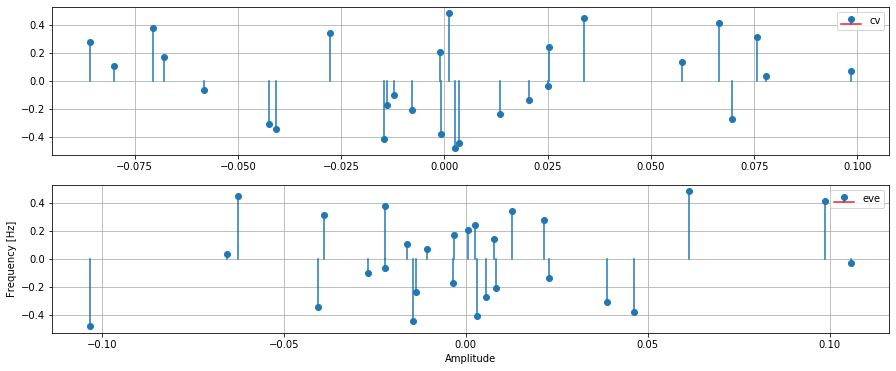

	-- 2 SEC Timeframe --
cv length 14 eve length 14
[cv]
overall pearson correlation (r, p): -0.467 0.092
[eve]
overall pearson correlation (r, p): -0.61 0.02
-- diff: 0.14371358647149218, 0.07206759459267532


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


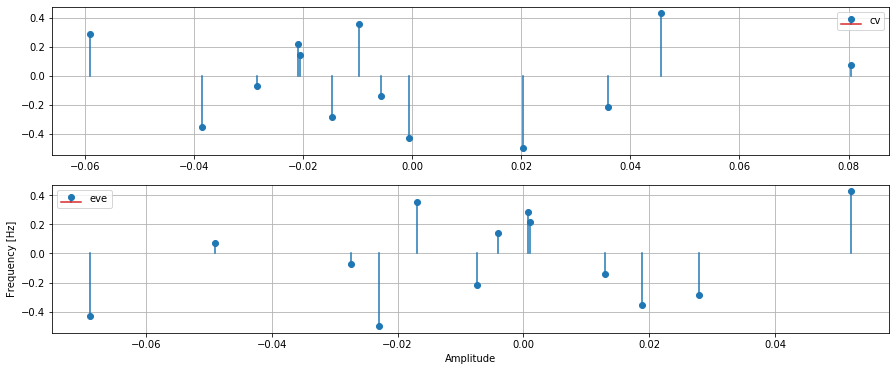

	-- 3 SEC Timeframe --
cv length 9 eve length 9
[cv]
overall pearson correlation (r, p): -0.575 0.105
[eve]
overall pearson correlation (r, p): -0.534 0.139
-- diff: -0.04091789468900764, -0.03329519204189155


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


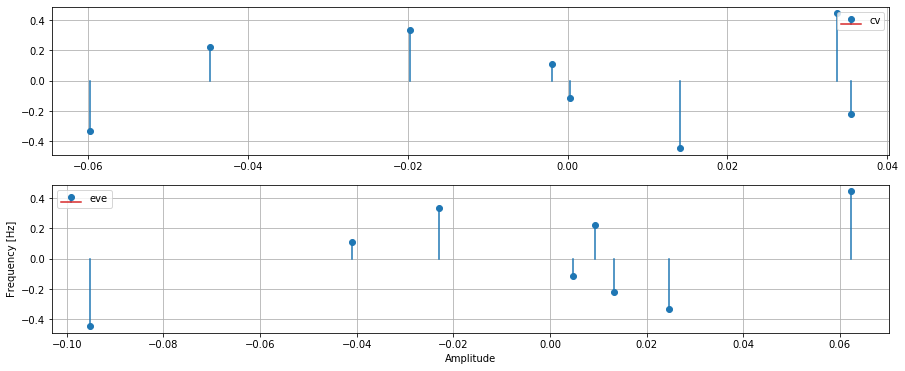

	-- 4 SEC Timeframe --
cv length 7 eve length 7
[cv]
overall pearson correlation (r, p): -0.647 0.117
[eve]
overall pearson correlation (r, p): -0.651 0.113
-- diff: 0.004268312995775458, 0.003194189895204008


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


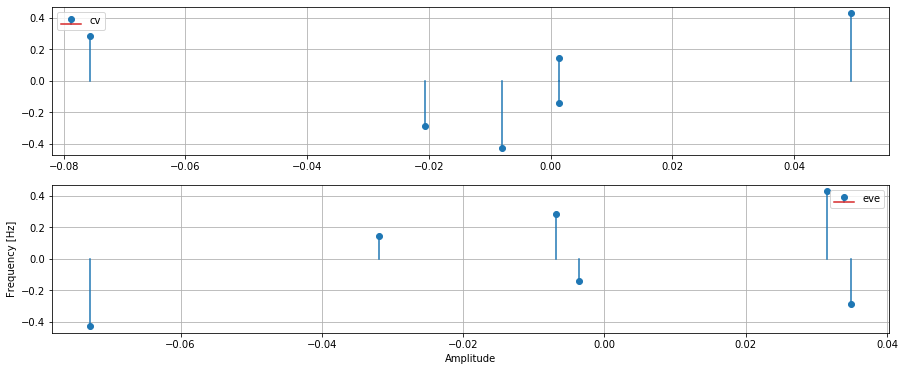

	-- 5 SEC Timeframe --
cv length 5 eve length 5
[cv]
overall pearson correlation (r, p): -0.815 0.093
[eve]
overall pearson correlation (r, p): -0.703 0.186
-- diff: -0.11202824983202908, -0.09263320194423066


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


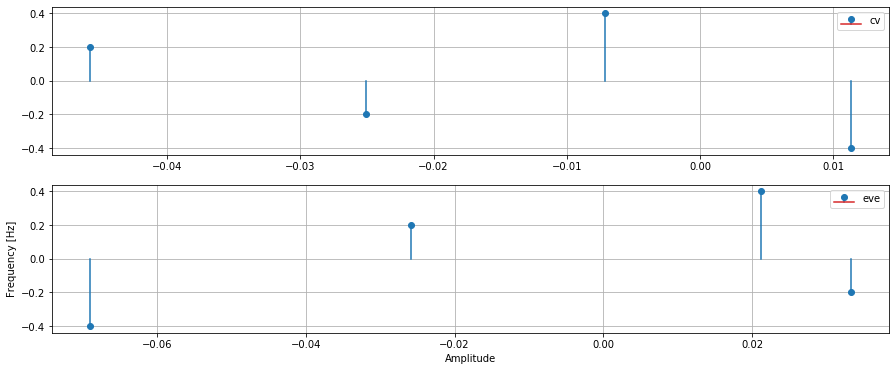

	-- 6 SEC Timeframe --
cv length 4 eve length 4
[cv]
overall pearson correlation (r, p): -0.703 0.297
[eve]
overall pearson correlation (r, p): -0.936 0.064
-- diff: 0.2335922241189271, 0.2335922241189271


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


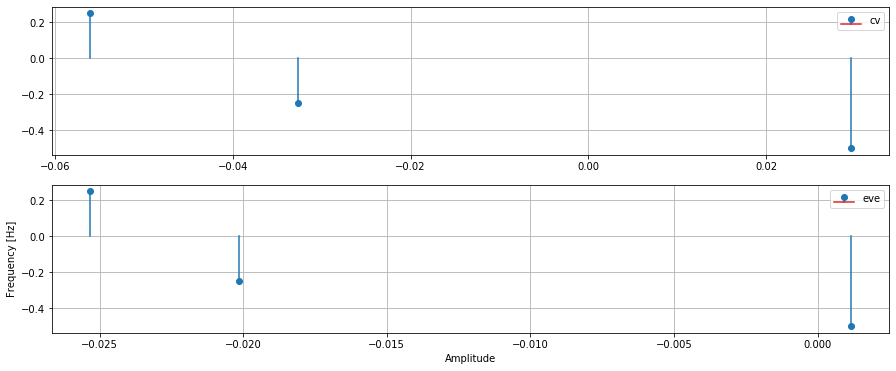

** after clean cv data, remove ratio 0.014818140996856743 

eve freq =  30.0  | cv freq =  16.0

**step_31
	-- 1 SEC Timeframe --
cv length 117 eve length 117
[cv]
overall pearson correlation (r, p): -0.169 0.069
[eve]
overall pearson correlation (r, p): 0.221 0.017
-- diff: -0.3894054200276982, 0.052085882100795795


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


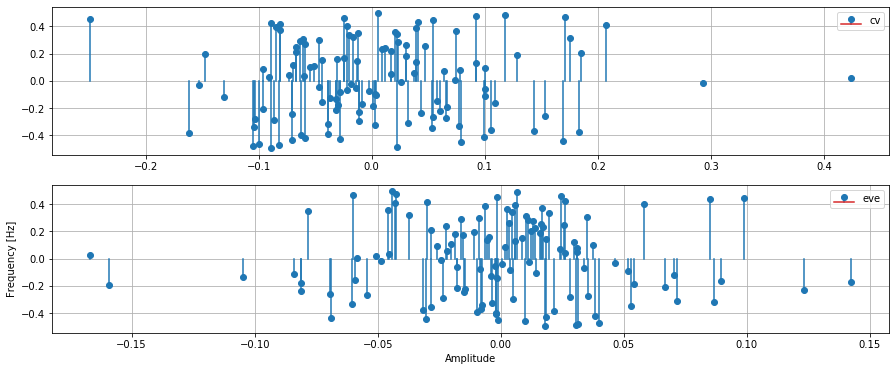

	-- 2 SEC Timeframe --
cv length 58 eve length 58
[cv]
overall pearson correlation (r, p): -0.209 0.116
[eve]
overall pearson correlation (r, p): 0.239 0.071
-- diff: -0.4479960720604569, 0.045212446925499555


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


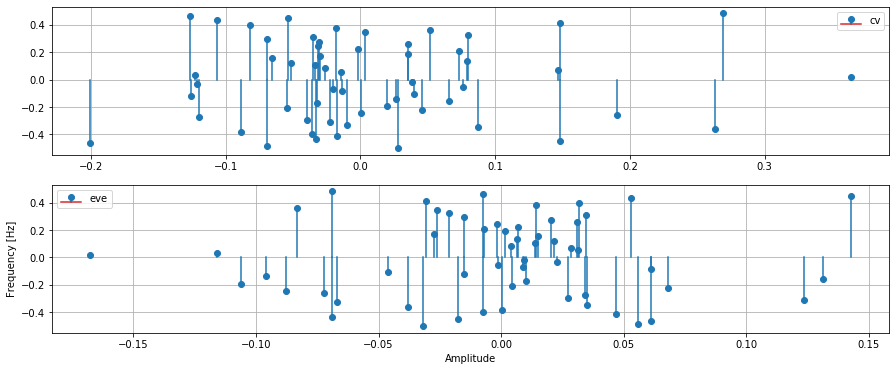

	-- 3 SEC Timeframe --
cv length 39 eve length 39
[cv]
overall pearson correlation (r, p): -0.25 0.124
[eve]
overall pearson correlation (r, p): 0.237 0.146
-- diff: -0.48771223571934097, -0.021243244198337036


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


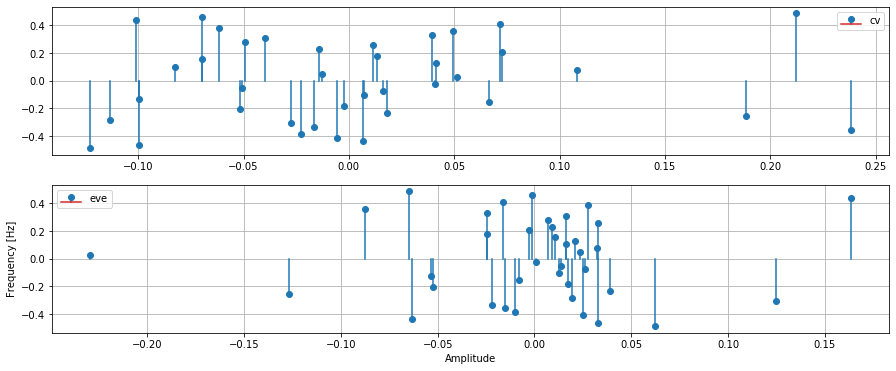

	-- 4 SEC Timeframe --
cv length 29 eve length 29
[cv]
overall pearson correlation (r, p): -0.308 0.104
[eve]
overall pearson correlation (r, p): 0.285 0.135
-- diff: -0.5928051800086631, -0.03063013030060474


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


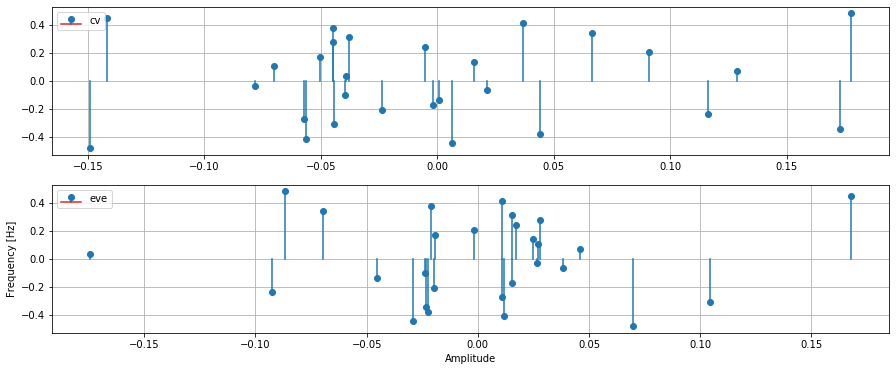

	-- 5 SEC Timeframe --
cv length 23 eve length 23
[cv]
overall pearson correlation (r, p): -0.367 0.085
[eve]
overall pearson correlation (r, p): 0.33 0.125
-- diff: -0.6962577790707412, -0.03939757848916016


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


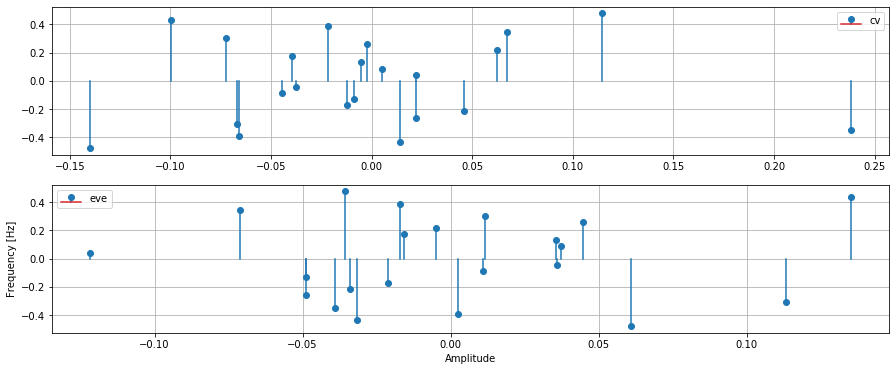

	-- 6 SEC Timeframe --
cv length 19 eve length 19
[cv]
overall pearson correlation (r, p): -0.388 0.101
[eve]
overall pearson correlation (r, p): 0.379 0.109
-- diff: -0.7668812297499246, -0.008607395370756582


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


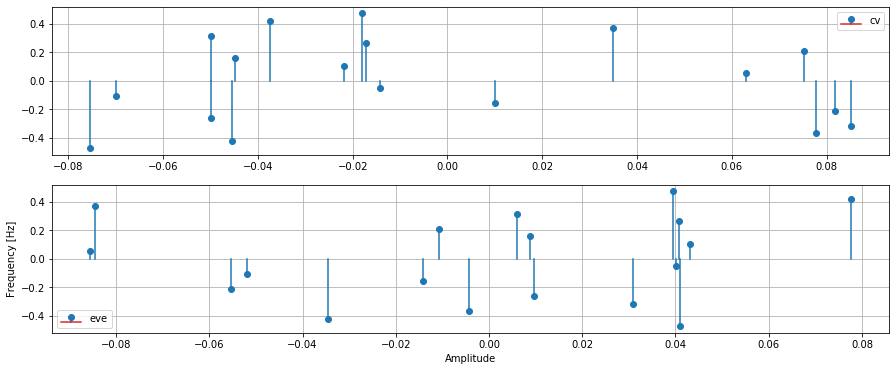

** after clean cv data, remove ratio 0.043261231281197965 

eve freq =  30.0  | cv freq =  16.0

**step_32
	-- 1 SEC Timeframe --
cv length 29 eve length 29
[cv]
overall pearson correlation (r, p): 0.418 0.024
[eve]
overall pearson correlation (r, p): -0.201 0.304
-- diff: 0.6195223840050887, -0.2798551533024526


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


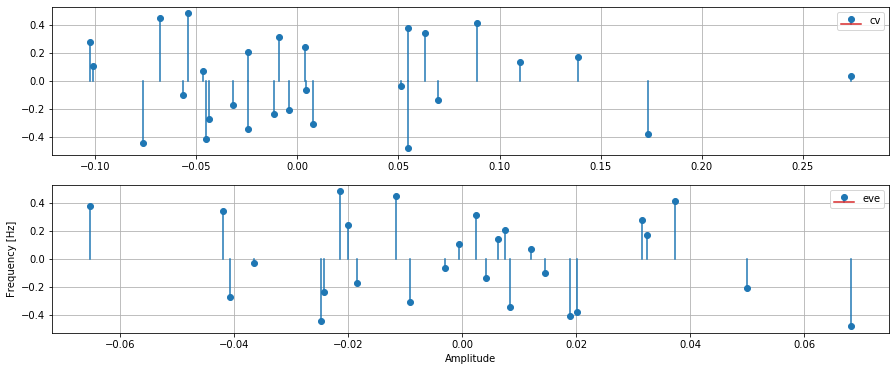

	-- 2 SEC Timeframe --
cv length 14 eve length 14
[cv]
overall pearson correlation (r, p): 0.5 0.069
[eve]
overall pearson correlation (r, p): -0.114 0.698
-- diff: 0.6135947943258354, -0.629522313949359


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


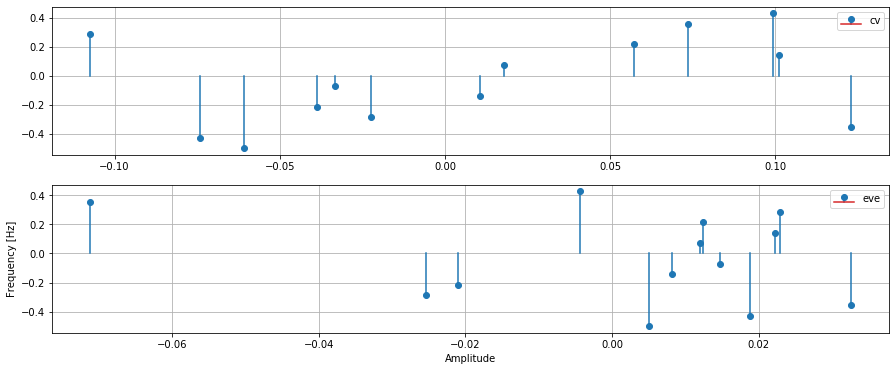

	-- 3 SEC Timeframe --
cv length 9 eve length 9
[cv]
overall pearson correlation (r, p): 0.648 0.059
[eve]
overall pearson correlation (r, p): -0.175 0.653
-- diff: 0.8221274105283829, -0.5938964148061426


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


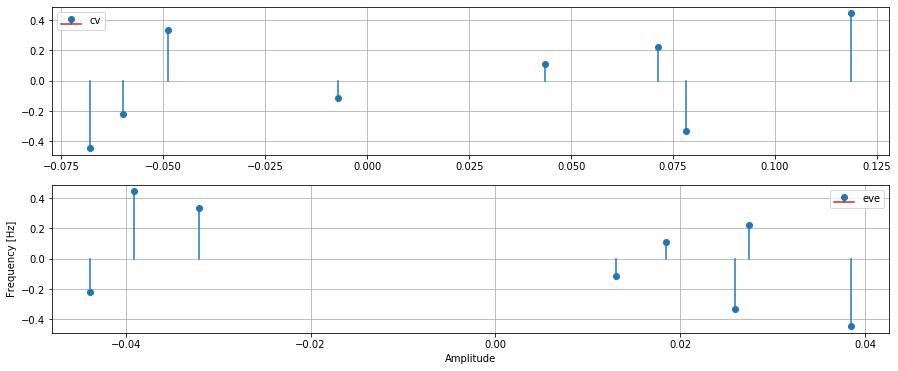

	-- 4 SEC Timeframe --
cv length 7 eve length 7
[cv]
overall pearson correlation (r, p): 0.569 0.183
[eve]
overall pearson correlation (r, p): -0.21 0.652
-- diff: 0.7783456364266388, -0.46929114855091575


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


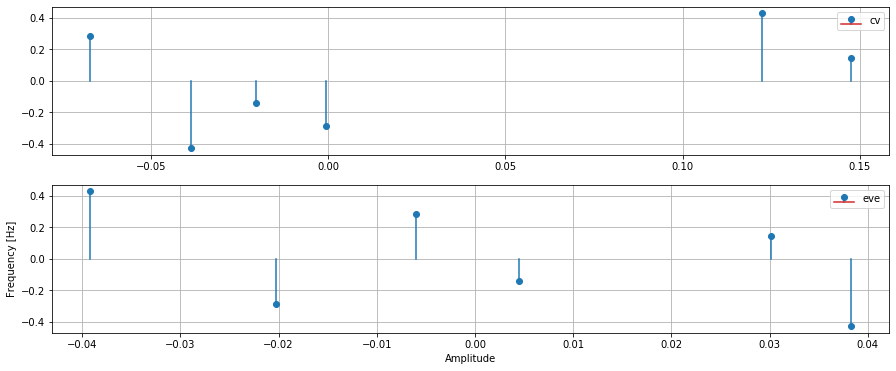

	-- 5 SEC Timeframe --
cv length 5 eve length 5
[cv]
overall pearson correlation (r, p): 0.711 0.178
[eve]
overall pearson correlation (r, p): -0.19 0.76
-- diff: 0.9008150079150175, -0.5813046448185533


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


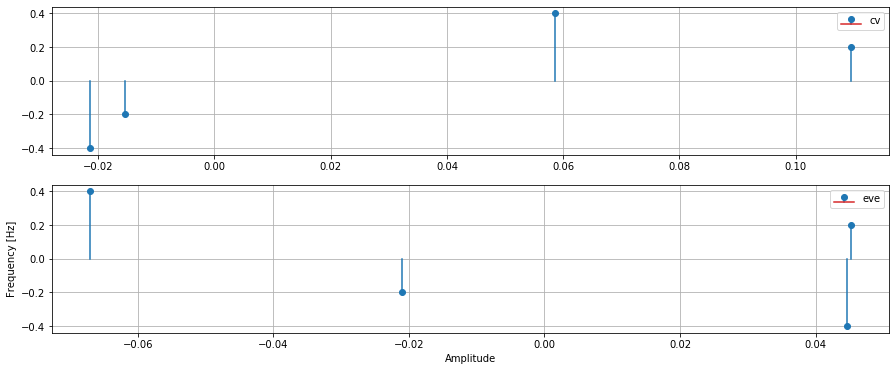

	-- 6 SEC Timeframe --
cv length 4 eve length 4
[cv]
overall pearson correlation (r, p): 0.952 0.048
[eve]
overall pearson correlation (r, p): -0.264 0.736
-- diff: 1.2169025111531138, -0.6880178051707011


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


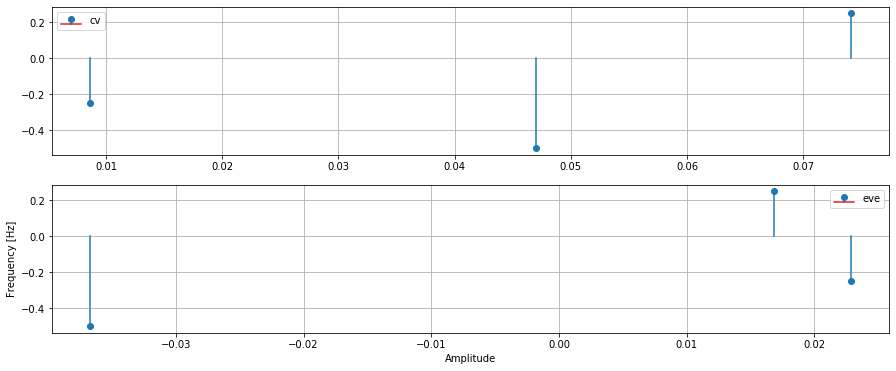

In [64]:
cv_1, s30_cv1, s31_cv1, s32_cv1 = input_data('train01')
run('30', s30_cv1, 'train01')
run('31', s31_cv1, 'train01')
run('32', s32_cv1, 'train01')

C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


** after clean cv data, remove ratio 0.04347826086956519 

eve freq =  30.0  | cv freq =  6.0

**step_30
	-- 1 SEC Timeframe --
cv length 29 eve length 29
[cv]
overall pearson correlation (r, p): 0.323 0.1
[eve]
overall pearson correlation (r, p): -0.704 0.0
-- diff: 1.0277868461017308, 0.09995515237031204


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


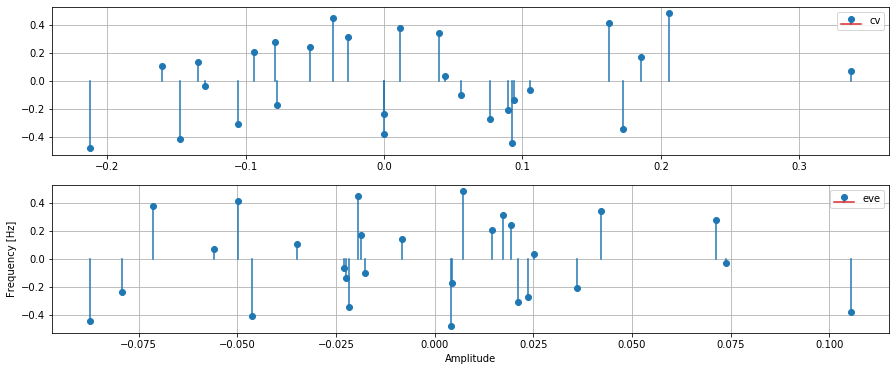

	-- 2 SEC Timeframe --
cv length 14 eve length 14
[cv]
overall pearson correlation (r, p): 0.445 0.111
[eve]
overall pearson correlation (r, p): -0.733 0.003
-- diff: 1.1776338237501287, 0.10837209447045576


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


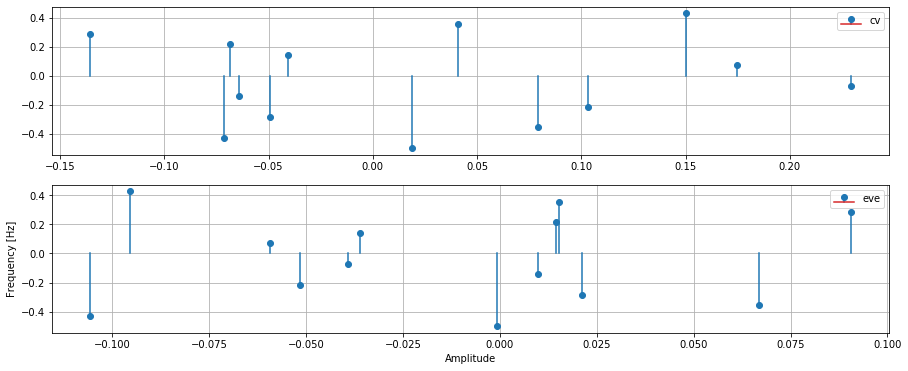

	-- 3 SEC Timeframe --
cv length 9 eve length 9
[cv]
overall pearson correlation (r, p): 0.265 0.491
[eve]
overall pearson correlation (r, p): -0.744 0.021
-- diff: 1.0092823681649887, 0.46924406960211934


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


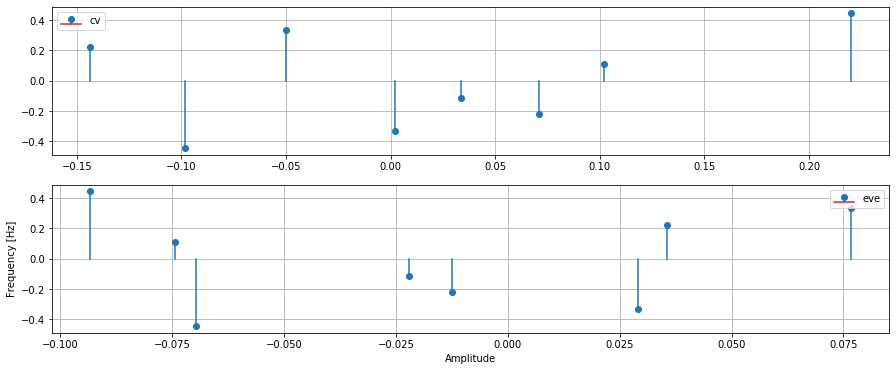

	-- 4 SEC Timeframe --
cv length 7 eve length 7
[cv]
overall pearson correlation (r, p): 0.465 0.294
[eve]
overall pearson correlation (r, p): -0.77 0.043
-- diff: 1.2345108682129278, 0.250819475299765


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


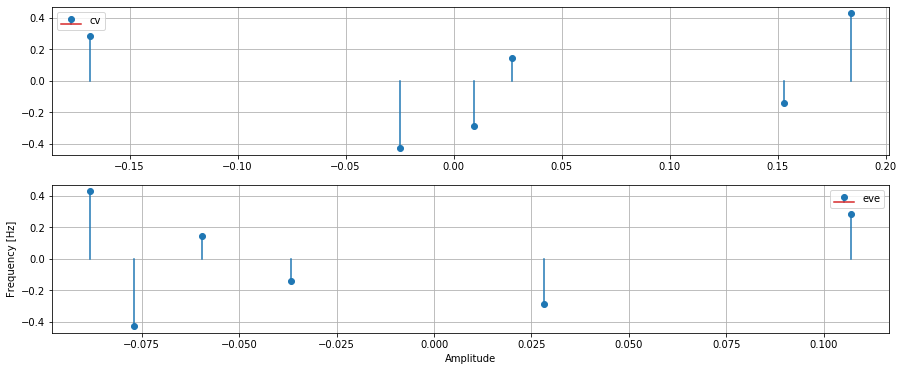

	-- 5 SEC Timeframe --
cv length 5 eve length 5
[cv]
overall pearson correlation (r, p): 0.277 0.652
[eve]
overall pearson correlation (r, p): -0.847 0.07
-- diff: 1.1238843691542248, 0.5811031748581432


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


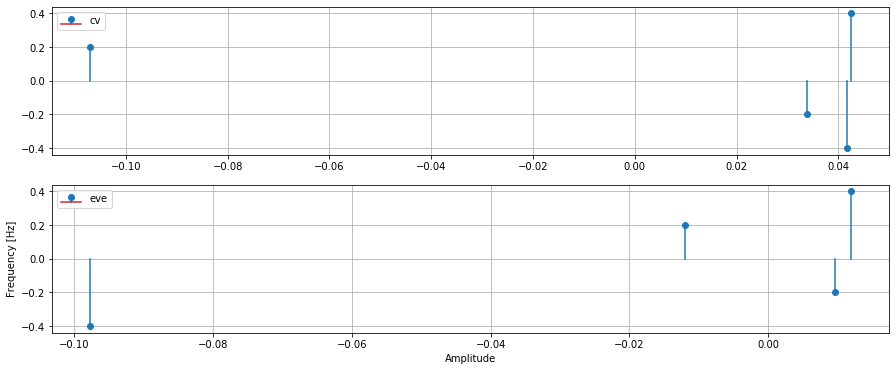

	-- 6 SEC Timeframe --
cv length 4 eve length 4
[cv]
overall pearson correlation (r, p): 0.188 0.812
[eve]
overall pearson correlation (r, p): -0.812 0.188
-- diff: 1.0003624354744731, 0.6246369117864787


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


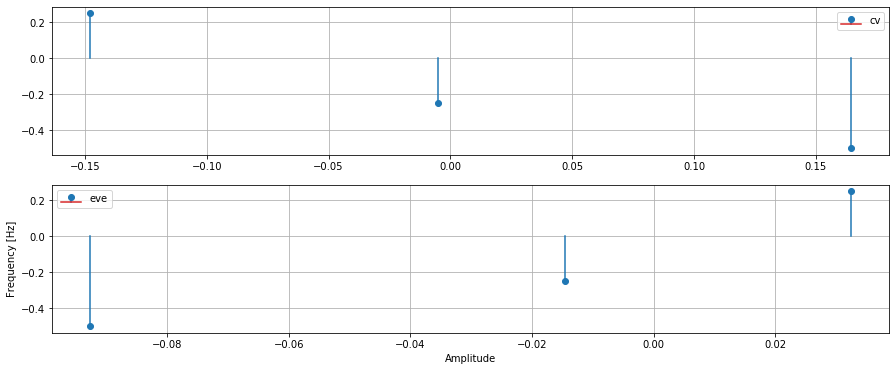

** after clean cv data, remove ratio 0.1670886075949367 

eve freq =  30.0  | cv freq =  12.0

**step_31
	-- 1 SEC Timeframe --
cv length 29 eve length 29
[cv]
overall pearson correlation (r, p): -0.578 0.002
[eve]
overall pearson correlation (r, p): -0.414 0.032
-- diff: -0.16469099266584025, -0.03040765219761131


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


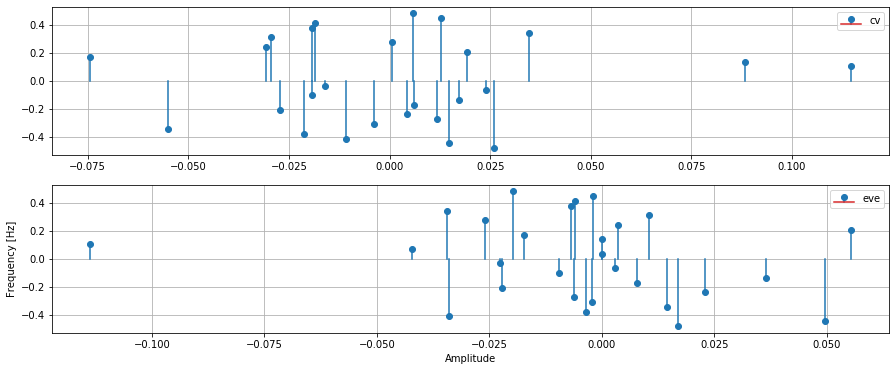

	-- 2 SEC Timeframe --
cv length 14 eve length 14
[cv]
overall pearson correlation (r, p): -0.63 0.021
[eve]
overall pearson correlation (r, p): -0.479 0.083
-- diff: -0.1510440169829384, -0.06220232915712928


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


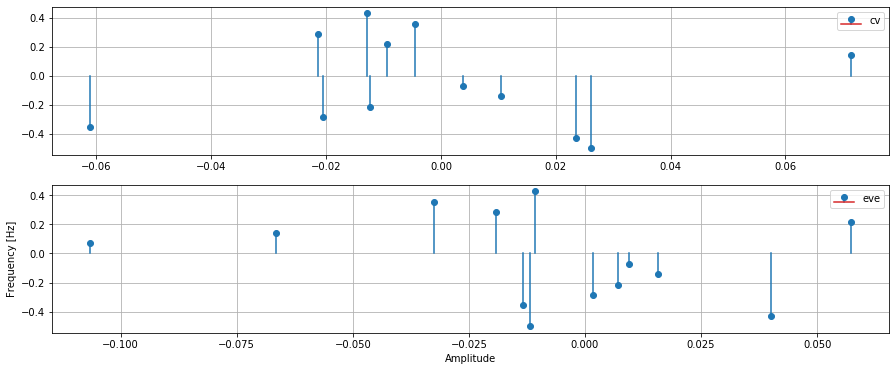

	-- 3 SEC Timeframe --
cv length 9 eve length 9
[cv]
overall pearson correlation (r, p): -0.237 0.539
[eve]
overall pearson correlation (r, p): -0.509 0.162
-- diff: 0.2716099399699219, 0.37713105883586684


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


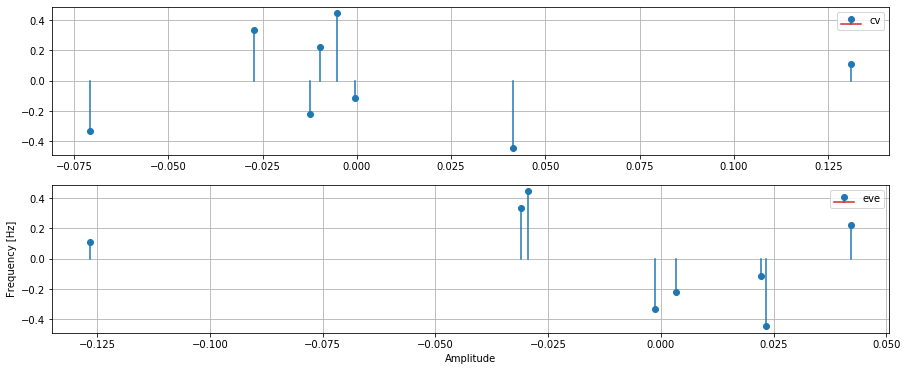

	-- 4 SEC Timeframe --
cv length 7 eve length 7
[cv]
overall pearson correlation (r, p): -0.457 0.303
[eve]
overall pearson correlation (r, p): -0.498 0.256
-- diff: 0.040968855760593004, 0.04719958941161562


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


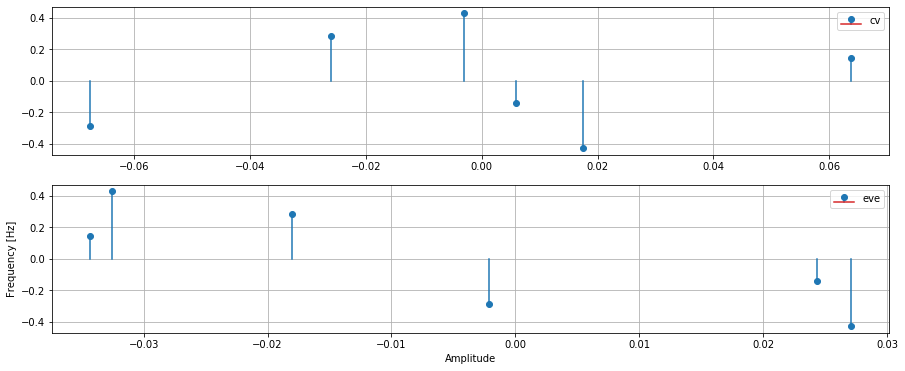

	-- 5 SEC Timeframe --
cv length 5 eve length 5
[cv]
overall pearson correlation (r, p): -0.715 0.175
[eve]
overall pearson correlation (r, p): -0.77 0.128
-- diff: 0.055158673748706755, 0.047020324821828496


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


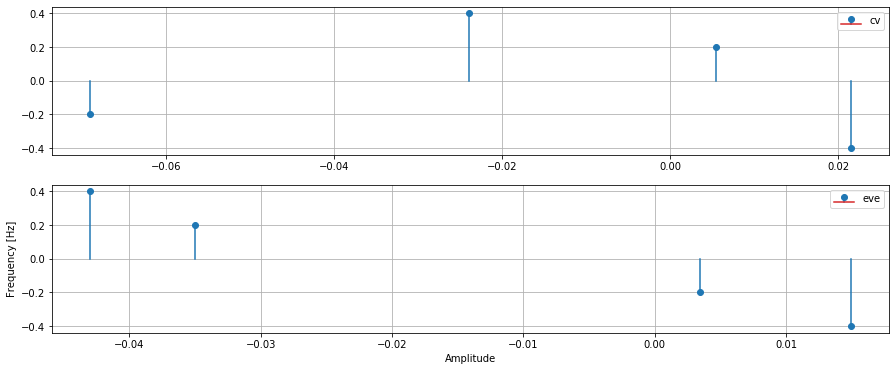

	-- 6 SEC Timeframe --
cv length 4 eve length 4
[cv]
overall pearson correlation (r, p): -0.847 0.153
[eve]
overall pearson correlation (r, p): -0.81 0.19
-- diff: -0.037505546615841934, -0.037505546615841934


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


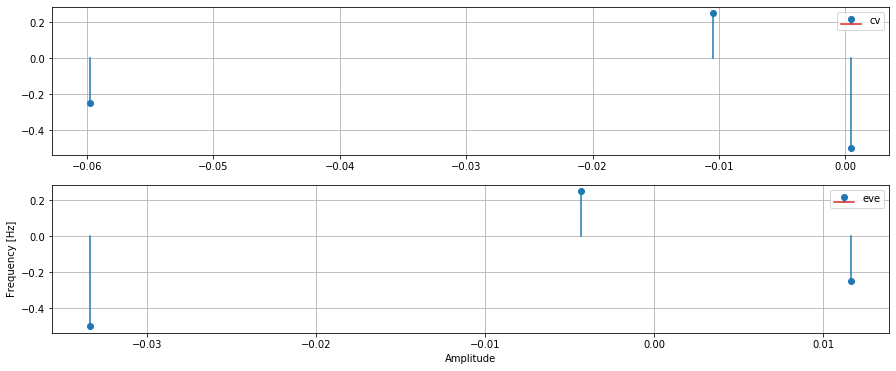

** after clean cv data, remove ratio 0.008695652173912993 

eve freq =  30.0  | cv freq =  10.0

**step_32
	-- 1 SEC Timeframe --
cv length 9 eve length 9
[cv]
overall pearson correlation (r, p): -0.71 0.049
[eve]
overall pearson correlation (r, p): -0.539 0.134
-- diff: -0.1705553589050569, -0.08544237329592469


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


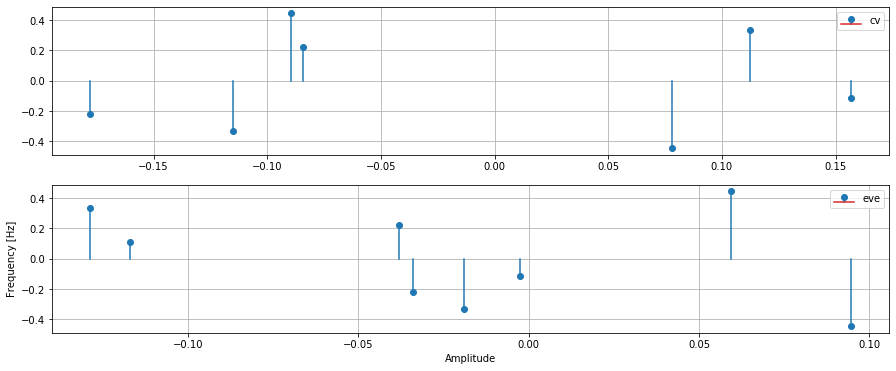

	-- 2 SEC Timeframe --
cv length 4 eve length 4
[cv]
overall pearson correlation (r, p): -0.852 0.148
[eve]
overall pearson correlation (r, p): -0.619 0.381
-- diff: -0.23227074283822302, -0.23227074283822302


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


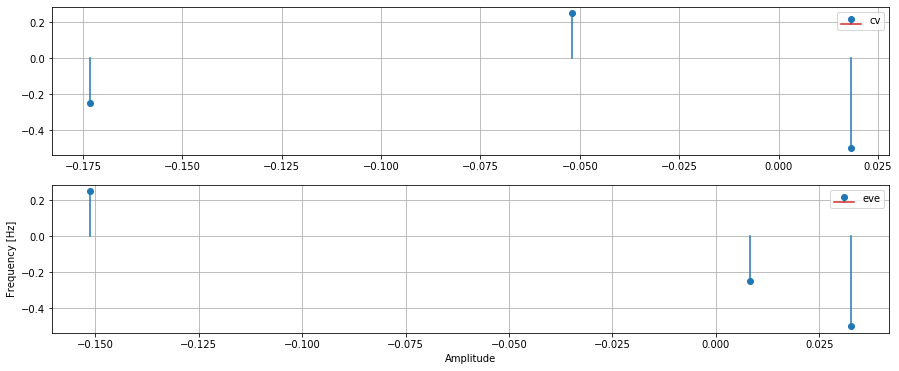

	-- 3 SEC Timeframe --
cv length 3 eve length 3
[cv]
overall pearson correlation (r, p): -0.806 0.403
[eve]
overall pearson correlation (r, p): -0.722 0.487
-- diff: -0.0841138323912144, -0.08329160010129427


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


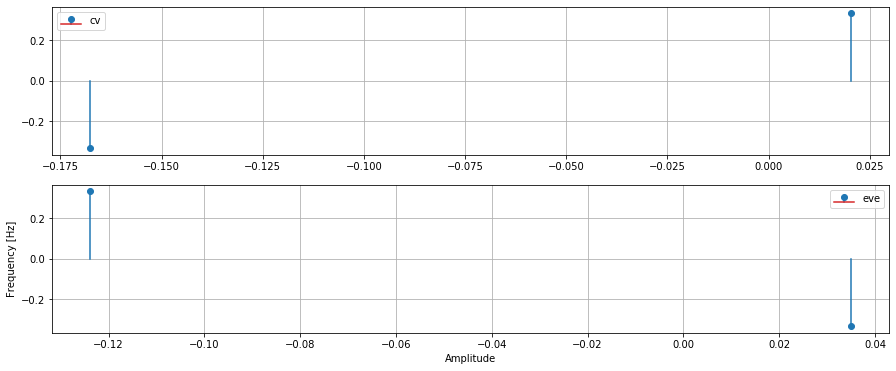

	-- 4 SEC Timeframe --
cv length 2 eve length 2
[cv]
overall pearson correlation (r, p): -1.0 1.0
[eve]
overall pearson correlation (r, p): -1.0 1.0
-- diff: 0.0, 0.0


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


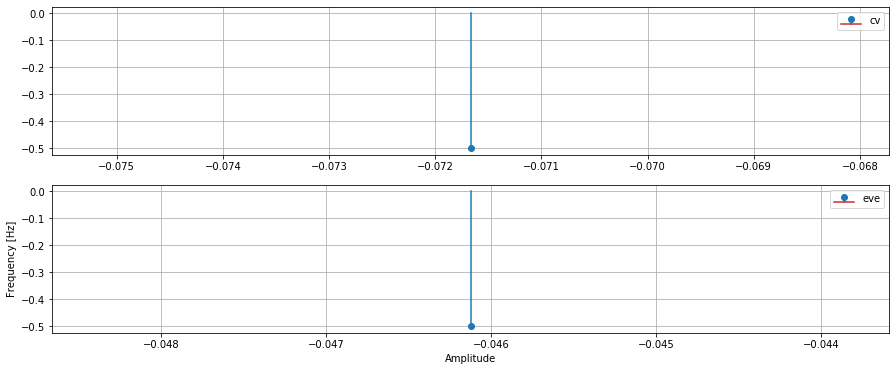

	-- 5 SEC Timeframe --
cv length 1 eve length 1
[cv]
	-- 6 SEC Timeframe --
cv length 1 eve length 1
[cv]


In [65]:
cv_2, s30_cv2, s31_cv2, s32_cv2  = input_data('train02')
run('30', s30_cv2, 'train02')
run('31', s31_cv2, 'train02')
run('32', s32_cv2, 'train02')